In [22]:
#!/bin/env python

import os

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import csv
import sys
import json
import math
from nltk.tokenize import word_tokenize

# ./compare-psylle.py Cpruni_occurrences_binary.json extracted_psyllid_entities.txt extracted_psyllid_relations.txt >eval.json

sys.stdout.write('COMPARISON STARTED\n')
ref_filepath = 'data/ref/cpruni_occurrences_binary.json'
sys.stdout.write(ref_filepath) # label filepath

COMPARISON STARTED
data/ref/cpruni_occurrences_binary.json

39

In [23]:
#########################
## Load Subdirectories ##
#########################

# eact subdirectory is an output of a variation of the same pipeline
# with different strategies implemented (for comparison)

def get_child_dir_paths(dir_path):
    child_names = os.listdir(dir_path)
    child_paths = [os.path.join(dir_path,child_name) for child_name in child_names]
    dir_paths = [child_path for child_path in child_paths if os.path.isdir(child_path)]
    return dir_paths

pred_dir_path = 'data/pred'

pred_filepaths = dict()

c = 0

for dirpath in get_child_dir_paths(pred_dir_path):
    pred_ent_filepaths = []
    pred_rel_filepaths = []
    for filepath in os.listdir(dirpath):
        filepath = os.path.join(pred_dir_path,str(c),filepath)
        
        if 'ent' in filepath:
            pred_ent_filepaths.append(filepath)
        elif 'rel' in filepath:
            pred_rel_filepaths.append(filepath)

        pred_filepaths_in_dir = list(zip(pred_ent_filepaths, pred_rel_filepaths))
        pred_filepaths[c] = pred_filepaths_in_dir
    c += 1


# e.g. of pred_filepaths:
# {0: [('data/pred/0/extracted_psyllid_entities.txt',
#    'data/pred/0/extracted_psyllid_relations.txt')],
#  1: [('data/pred/1/extracted_psyllid_entities.txt',
#    'data/pred/1/extracted_psyllid_relations.txt')]}

reference_nomeclature_db_filepath = '../../../text-mining-workflow/ancillaries/psylve/psyllid_taxa.txt'
with open(reference_nomeclature_db_filepath, 'r') as f:
    reference_nomeclature_db = f.read()



In [24]:

#########################
## Evaluation Formulas ##
#########################

# Either reference and prediction document names are the same
def same_doc(ref, pred):
    return pred == ref or pred == ref + '_translation'


# Similarity between vectors
def sim_vector(ref, pred):
    #for token1 in word_tokenize(ref['acceptedNameUsage'].lower()):
        #for token2 in word_tokenize(pred['CANONICAL'].lower()):
            #if token1==token2:
            # FOR ALL HEMIPTERA: if token2 in reference_nomeclature_db.lower():
    if 'psyll' in pred['CANONICAL'].lower():
        return 1.0
    return 0.0

# Similarity between locations
def sim_location(ref, pred):
    for token1 in word_tokenize(ref['country'].lower()):
        for token2 in word_tokenize(pred['FORM'].lower()):
            if token1==token2:
                return 1.0
    return 0.0


# Similarity between hosts
def sim_host(ref, pred):
    for token1 in word_tokenize(ref['hostPlantLatinName'].lower()):
        for token2 in word_tokenize(pred['CANONICAL'].lower()):
            if token1==token2:
                return 1.0
    return 0.0

# Similarity between dates
def sim_date(ref, pred):
    if ref['eventDate'][-4:] == pred['FORM']:
        return 1.0
    return 0.0


TYPES = ('vector', 'location', 'host', 'date')

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))
        

################
## Pairing up ##
################


sim_fun = {
    'vector': sim_vector,
    'location': sim_location,
    'host': sim_host,
    'date': sim_date
}


def sim(ref, pred):
    if ref['type'] != pred['TYPE']:
        return 0.0
    if not same_doc(ref['filename'], pred['DOC']):
        return 0.0
    return sim_fun[ref['type']](ref, pred)


def find_best_ent(paired_pred, ref_ent, pred_entities):
    max_sim = 0.0
    best_pred = None
    for pred_ent in pred_entities:
        if pred_ent in paired_pred:
            continue
        s = sim(ref_ent, pred_ent)
        if s == 0.0:
            continue
        if s > max_sim:
            max_sim = s
            best_pred = pred_ent
    return best_pred, max_sim


def pair_filter(pair, doc=None, type_=None, cat=None):
    r = pair['ref']
    p = pair['pred']
    if doc is not None:
        if r is not None and r['filename'] != doc:
            return False
        if p is not None and not same_doc(doc, p['DOC']):
            return False
    if type_ is not None:
        if r is not None and r['type'] != type_:
            return False
        if p is not None and p['TYPE'] != type_:
            return False
    if cat is not None:
        return cat == pair['cat']
    return True


################
## Evaluation ##
################

def evaluate(ref_filepath, pred_ent_filepath, pred_rel_filepath):       
    with open(ref_filepath) as f:
        reference = json.load(f)
    ref_documents = set(ref['common']['filename'] for ref in reference)
    ref_entities = set()
    for ref in reference:
        fn = ref['common']['filename']
        ref_entities.add(hashabledict(ref['left']))
        ref_entities.add(hashabledict(ref['right']))


    with open(pred_ent_filepath, newline='') as f:
        entcsv = csv.DictReader(f, delimiter='\t')
        pred_entities = set(hashabledict(row) for row in entcsv)


    with open(pred_rel_filepath, newline='') as f:
        relcsv = csv.DictReader(f, delimiter='\t')
        pred_relations = set(hashabledict(row) for row in relcsv)



    TRUE_POSITIVE = 'True Positive'
    FALSE_POSITIVE = 'False Positive'
    FALSE_NEGATIVE = 'False Negative'


    ent_pairs = []
    paired_pred = set()
    for ref_ent in ref_entities:
        pred_ent, s = find_best_ent(paired_pred, ref_ent, pred_entities)
        if pred_ent is not None:
            paired_pred.add(pred_ent)
            cat = TRUE_POSITIVE
        else:
            cat = FALSE_NEGATIVE
        ent_pairs.append({'ref': ref_ent, 'pred': pred_ent, 'sim': s, 'cat': cat})
    for pred_ent in pred_entities:
        if pred_ent not in paired_pred:
            ent_pairs.append({'ref': None, 'pred': pred_ent, 'sim': 0.0, 'cat': FALSE_POSITIVE})


    def evaluate(pairs):
        tp = list(p for p in pairs if pair_filter(p, cat=TRUE_POSITIVE))
        fp = list(p for p in pairs if pair_filter(p, cat=FALSE_POSITIVE))
        fn = list(p for p in pairs if pair_filter(p, cat=FALSE_NEGATIVE))
        if len(tp) + len(fn) == 0:
            recall = math.nan
        else:
            recall = float(len(tp)) / (len(tp) + len(fn))
        if len(tp) + len(fp) == 0:
            precision = math.nan
        else:
            precision = float(len(tp)) / (len(tp) + len(fp))
        if recall + precision == 0:
            f1 = math.nan
        else:
            f1 = 2 * recall * precision / (recall + precision)
        return recall, precision, f1


    ent_eval = {}
    for doc in ref_documents:
        if str(doc) not in str(pred_entities):
            continue
        ent_doc_eval = {}
        for type_ in TYPES:
            pairs = list(p for p in ent_pairs if pair_filter(p, doc=doc, type_=type_))
            recall, precision, f1 = evaluate(pairs)
            ent_doc_eval[type_] = {
                'pairs': pairs,
                'recall': recall,
                'precision': precision,
                'f1': f1
            }
        ent_eval[doc] = ent_doc_eval
        recall, precision, f1 = evaluate(ent_pairs)
        ent_eval['global'] = {
            'recall': recall,
            'precision': precision,
            'f1': f1
        }

    return ent_eval


ent_evals = {}
c = 0

for dir,files in pred_filepaths.items():
    pred_ent_filepath = [path for path in files[0] if 'ent' in path][0]
    pred_rel_filepath = [path for path in files[0] if 'rel' in path][0]
    comparison_filepath = os.path.join(pred_dir_path,str(dir),'comparison.json')
    
    ent_eval = evaluate(ref_filepath, pred_ent_filepath, pred_rel_filepath)
    with open(comparison_filepath, 'w+') as f:
        json.dump(ent_eval, f, indent=4)
    ent_evals[c] = ent_eval
    c+=1

with open('data/comparison.json', 'w+') as f:
    json.dump(ent_evals, f, indent=4)


#json.dump(ent_eval, sys.stdout, indent=4)


In [25]:
import sys
import json
from types import NoneType
import pandas as pd
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, recall_score, precision_score

sys.stdout.write('COMPUTING SCORES\n')


####################
## Subdirectories ##
####################
import os

def get_child_dir_paths(dir_path):
    child_names = os.listdir(dir_path)
    child_paths = [os.path.join(dir_path,child_name) for child_name in child_names]
    dir_paths = [child_path for child_path in child_paths if os.path.isdir(child_path)]
    return dir_paths

pred_dir_path = 'data/pred'

comp_filepaths = dict()

c = 0

for dirpath in get_child_dir_paths(pred_dir_path):
    comp_filepath = []
    for filepath in os.listdir(dirpath):
        filepath = os.path.join(pred_dir_path,str(c),filepath)
        if 'comp' in filepath:
            comp_filepath.append(filepath)

        comp_filepaths[c] = comp_filepath
    c += 1

# e.g. of pred_filepaths:
# {0: [('data/pred/0/extracted_psyllid_entities.txt',
#    'data/pred/0/extracted_psyllid_relations.txt')],
#  1: [('data/pred/1/extracted_psyllid_entities.txt',
#    'data/pred/1/extracted_psyllid_relations.txt')]}

save_dir = 'data/evaluation_results/'


#######################
##### conversion : ####
##### nested  dict ####
##### to dataframe ####
#######################


ref_df = dict(docname=[], entname=[], dir_n=[])
pred_df = dict(docname=[], entname=[], dir_n=[])

with open('data/comparison.json', 'r') as f:
    ent_evals = json.load(f)

for dir_n,comp_filepath in comp_filepaths.items():

    #open each json comparison.json file
    with open(comp_filepath[0], 'r') as f:
            ent_eval = json.load(f)
    len(ent_eval.items())
    if 'global' in ent_eval.keys():
        ent_eval.pop('global')

    for docname,entities in ent_eval.items():
        if docname == 'global':
            continue 
        for entname,pairs_n_scores in entities.items():
            if pairs_n_scores is NoneType:
                continue
            else:
                for pair in pairs_n_scores['pairs']:
                    #print((pair.keys())) # = 'ref', 'pred', 'sim', 'cat'
                    
                    try:
                        pair['ref'].items()
                        pair['pred'].items()
                    except AttributeError:
                        continue
                    for a,v in pair['ref'].items(): # attribute and value of entity
                        if a not in ref_df.keys():
                            ref_df[a] = []
                        ref_df[a].append(v)

                    for a,v in pair['pred'].items():
                        if a not in ref_df.keys():
                            pred_df[a] = []
                        pred_df[a].append(v)

                    ref_df['dir_n'].append(dir_n)
                    pred_df['dir_n'].append(dir_n)

                    ref_df['docname'].append(docname)
                    pred_df['docname'].append(docname)
                    
                    pred_df['entname'].append(entname)
                    ref_df['entname'].append(entname)

                    
                    sizes = []
                    for k in ref_df.keys():
                        sizes.append(len(ref_df[k]))
                    for k in ref_df.keys():
                        if len(ref_df[k]) < max(sizes):
                            ref_df[k].extend([math.nan]*(max(sizes) - len(ref_df[k])))
                    sizes = []
                    for k in pred_df.keys():
                        sizes.append(len(pred_df[k]))
                    for k in pred_df.keys():
                        if len(pred_df[k]) < max(sizes):
                            pred_df[k].extend([math.nan]*(max(sizes) - len(pred_df[k])))
            

ref_df = pd.DataFrame(ref_df)
pred_df = pd.DataFrame(pred_df)


COMPUTING SCORES


In [ ]:

################
## DUMMY DATA ##
################

## Create dummy data to be visualised using sklearn tools.

dummies = {'False Positive': (0,1),
            'False Negative': (1,0),
            'True Positive': (1,1),
            'True Negative': (0,0),
            }

dummies_inv = {v: k for k, v in dummies.items()}

def create_dummy(data):
    dummy_data = []
    for docname,entities in data.items():
        if (type(entities) is float) or (type(entities) is list):
            continue
        for entname,pairs_n_scores in entities.items():
            if (type(pairs_n_scores) is float) or (type(pairs_n_scores) is list):
                continue
            for pair in pairs_n_scores['pairs']:
                label = pair['cat']
                dummy_data.append(dummies[label])

    dummy_df = pd.DataFrame(dummy_data, columns =['ref', 'pred'])
    
    return dummy_df

dummies_df = dict()
for k,ent_eval in ent_evals.items():
    dummies_df[k] = create_dummy(ent_eval)

## dummies_df.keys() are numbers of folders

for k,dummy_df in dummies_df.items():
    ref_dummy, pred_dummy = dummy_df['ref'], dummy_df['pred']
    dummies_df[k]=list(zip(ref_dummy, pred_dummy))


# plotting confusion matrix
conf_mat = confusion_matrix(ref_dummy, pred_dummy)
sns.set(font_scale=1)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare')
matrix.set(xlabel='predicted', ylabel='actual')
matrix.figure.savefig("data/evaluation_results/confusion_matrix.png") 

print(classification_report(ref_dummy, pred_dummy))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       261
           1       0.13      0.32      0.19       125

    accuracy                           0.10       386
   macro avg       0.07      0.16      0.09       386
weighted avg       0.04      0.10      0.06       386

{'0': {(1, 1): 19, (1, 0): 109, (0, 1): 114}, '1': {(1, 1): 22, (1, 0): 103, (0, 1): 117}, '2': {(1, 1): 36, (0, 1): 182, (1, 0): 89}, '3': {(1, 1): 40, (0, 1): 261, (1, 0): 85}}


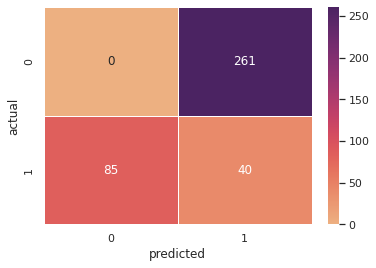

In [26]:


#############
## VISUALS ##
#############

from collections import Counter
from tools.visual import plot

counts =dict()

for k,dummy_df in dummies_df.items():
    counts[k] = dict(Counter(dummy_df))
print(counts)



In [27]:
import numpy as np
df = pd.DataFrame([count.values() for count in counts.values()],columns=[dummies_inv[k] for k in counts['0'].keys()])
summ_data = df.reset_index(level=0)

In [28]:

#df = df.reset_index()

for col_name in df.columns:
    df['Relative '+col_name] = np.subtract(np.array(df[col_name]),np.array([0]+df[col_name].tolist()[:-1]))

df


,True Positive,False Negative,False Positive,Relative True Positive,Relative False Negative,Relative False Positive
0,19,109,114,19,109,114
1,22,103,117,3,-6,3
2,36,182,89,14,79,-28
3,40,261,85,4,79,-4


In [29]:

rows = []
for col_name in df.columns:
    col = df[col_name]
    for i in df.index:
        rows.append((i,'_'.join([col_name.split(' ')[-2].lower()]+[col_name.split(' ')[-1].lower()]),df[col_name].iloc[i],('rel' in col_name.lower())))


# val is an absolute value
# rel_val is the relative value when compared to the pevious step in the evaluation
df = pd.DataFrame(rows, columns=['i','cat','val','rel_val'])
df.head()

,i,cat,val,rel_val
0,0,true_positive,19,False
1,1,true_positive,22,False
2,2,true_positive,36,False
3,3,true_positive,40,False
4,0,false_negative,109,False


In [30]:
# DUMMY
i=0
dummy_dict = dict()
#for col in pd.DataFrame(columns=df.columns):
dummy_dict['index'] = []
dummy_dict['cat'] = []
dummy_dict['i'] = []
for index, row in df.iterrows():
    cat = row['cat']
    val = row['val']
    for _ in range(val):
        dummy_dict['index'].append(i)
        i+=1
        dummy_dict['i'].append(row['i'])
        dummy_dict['cat'].append(row['cat'])


In [31]:
dummy_df = pd.DataFrame.from_dict(dummy_dict)
dummy_df.head()

,index,cat,i
0,0,true_positive,0
1,1,true_positive,0
2,2,true_positive,0
3,3,true_positive,0
4,4,true_positive,0


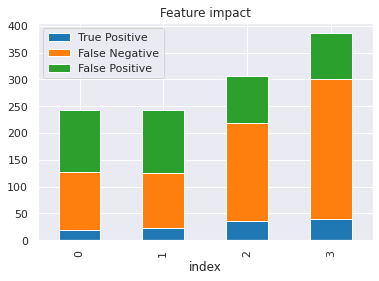

In [32]:
x = 'index'
y = 'val'
hue = 'cat'
palette = sns.color_palette('tab10',n_colors=2)
plot(x=x, hue=hue, data=summ_data,
    #select_data={'rel_val':[False]}, # only consider relative values (improvement given previous implemented feature)
    title = 'Feature impact' ,
    plot_type='stack',
    save_dir = save_dir,
    )

/home/elubrini/GitHub/psylve/venv/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


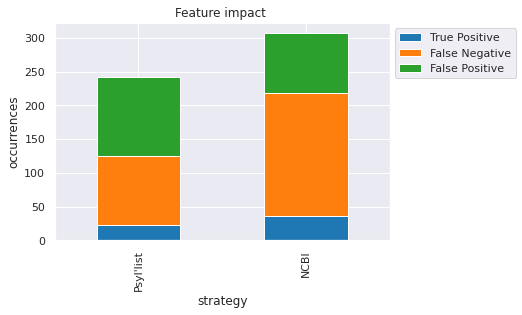

In [33]:
x = 'index'
y = 'val'
hue = 'cat'
palette = sns.color_palette('tab10',n_colors=2)

plot(x=x, y=y, hue=hue, data=summ_data,
    select_data={x:[1,2]}, 
    title = 'Feature impact ' ,
    plot_type='stack',
    legend_position='out',
    x_ticks = (range(2),['Psyl\'list', 'NCBI']),
    xlabel='strategy', ylabel='occurrences',
    save_dir = save_dir,
    )


/home/elubrini/GitHub/psylve/venv/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


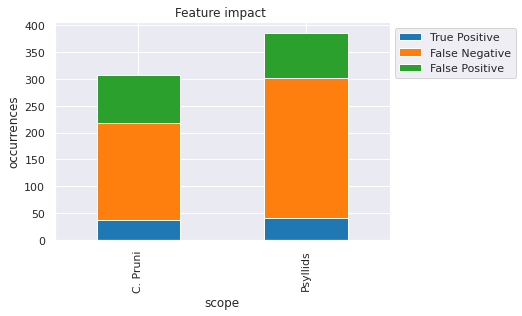

In [34]:
x = 'index'
y = 'val'
hue = 'cat'
palette = sns.color_palette('tab10',n_colors=2)

plot(x=x, y=y, hue=hue, data=summ_data,
    select_data={x:[2,3]}, 
    title = 'Feature impact ' ,
    plot_type='stack',
    legend_position='out',
    xlabel='scope', ylabel='occurrences',
    x_ticks = (range(2),['C. Pruni','Psyllids']),
    save_dir = save_dir,
    )
